In [2]:
!curl -O https://s3.amazonaws.com/pronto-data/open_data_year_one.zip
!unzip open_data_year_one.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70.8M  100 70.8M    0     0  6505k      0  0:00:11  0:00:11 --:--:-- 6314k
Archive:  open_data_year_one.zip
replace 2015_station_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

ValueError: I/O operation on closed file

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns; sns.set()

In [2]:
trip_data = pd.read_csv('2015_trip_data.csv',
                       parse_dates = ['starttime','stoptime'],
                       infer_datetime_format = True)
count = trip_data.apply(lambda x : x.count())
count.head()


trip_id         142846
starttime       142846
stoptime        142846
bikeid          142846
tripduration    142846
dtype: int64

## Exploring trips over time 

In [3]:
ind = pd.DatetimeIndex(trip_data.starttime)
trip_data['date'] = ind.date.astype('datetime64')
trip_data['hour'] = ind.hour
trip_data.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,date,hour
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960.0,2014-10-13,10
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970.0,2014-10-13,10
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988.0,2014-10-13,10
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977.0,2014-10-13,10
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971.0,2014-10-13,10


In [4]:
# Count trips by date
by_date = trip_data.pivot_table('trip_id',aggfunc = 'count', index='date',columns ='usertype')
by_date.head()

usertype,Annual Member,Short-Term Pass Holder
date,,
2014-10-13,284,125
2014-10-14,268,223
2014-10-15,212,101
2014-10-16,268,127
2014-10-17,195,99


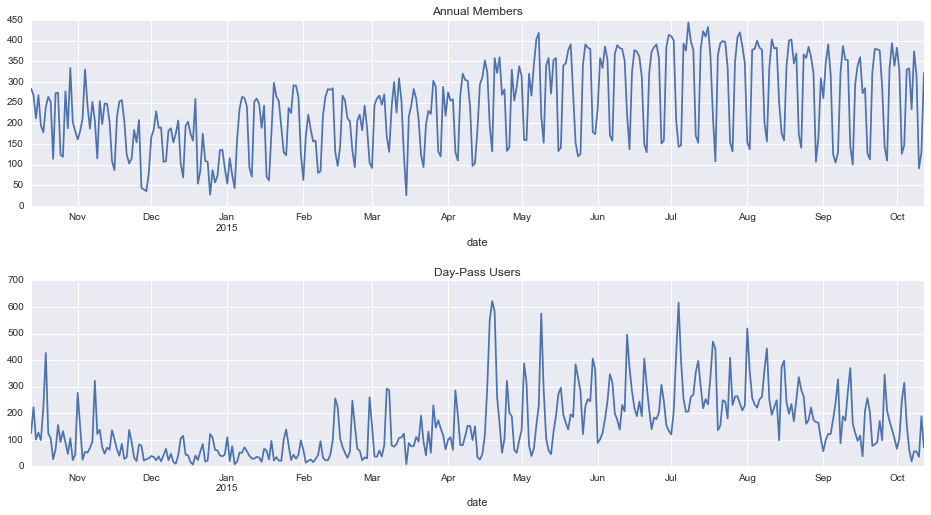

In [5]:
fig, ax = plt.subplots(2, figsize=(16,8))
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:,0].plot(ax=ax[0], title='Annual Members');
by_date.iloc[:,1].plot(ax=ax[1], title='Day-Pass Users');

In [6]:
by_weekday = by_date.groupby([by_date.index.year,
                              by_date.index.dayofweek]).mean()
by_weekday.head()

usertype  Annual Member  Short-Term Pass Holder
2014 0       211.833333               69.250000
     1       205.416667               62.000000
     2       197.666667               52.000000
     3       179.727273               58.090909
     4       183.000000               65.727273

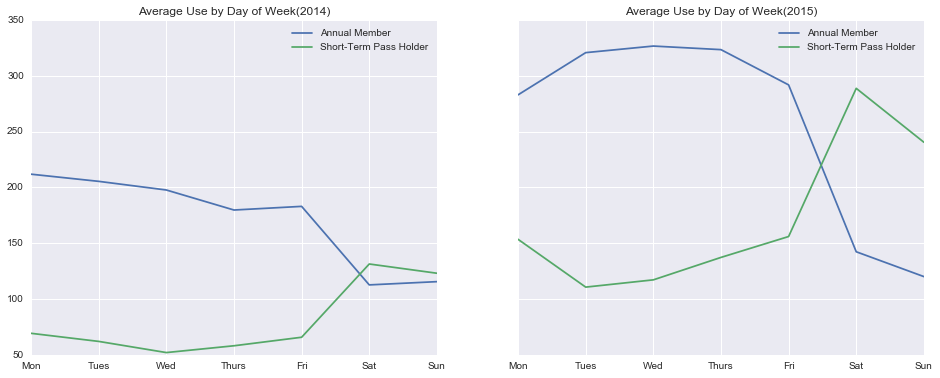

In [7]:
by_weekday.columns.name = None
fig, ax = plt.subplots(1, 2, figsize =(16,6), sharey = True)
by_weekday.loc[2014].plot(ax = ax[0],title = 'Average Use by Day of Week(2014)');
by_weekday.loc[2015].plot(ax = ax[1],title = 'Average Use by Day of Week(2015)');
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

In [8]:
#count trips by hour 
by_hour = trip_data.pivot_table('trip_id',aggfunc='count',index=['date','hour'],columns = 'usertype').fillna(0).reset_index('hour')

In [9]:
by_hour['weekend'] = (by_hour.index.dayofweek > 5)
by_hour = by_hour.groupby(['weekend', 'hour']).mean()
by_hour.index.set_levels([['weekday','weekend'],
                        ["{0}:00".format(i) for i in range(24)]],
                        inplace = True);
by_hour.columns.name = None

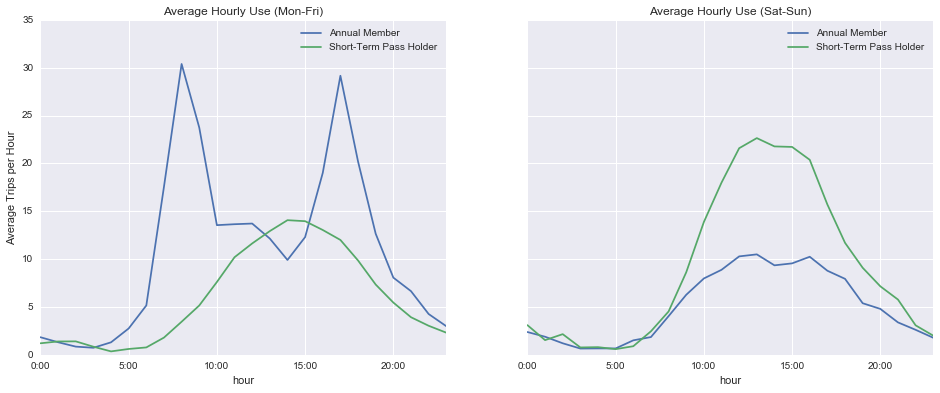

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_hour.loc['weekday'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour.loc['weekend'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
ax[0].set_ylabel('Average Trips per Hour');

## Trip Durations


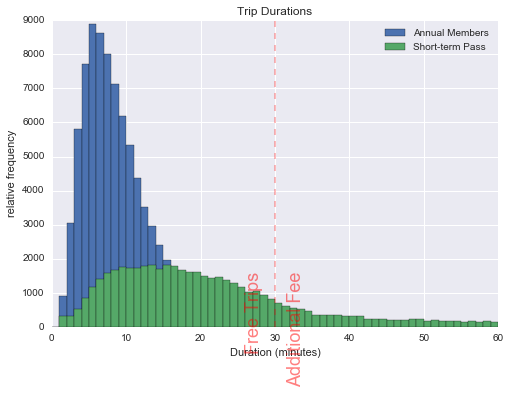

In [17]:
trip_data['minutes'] = trip_data.tripduration /60
trip_data.groupby('usertype')['minutes'].hist(bins = np.arange(61), alpha = 0.5,
                                              normed = True)
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.text(34, 0.09, "Free Trips\n\nAdditional Fee", ha='right',
         size=18, rotation=90, alpha=0.5, color='red')
plt.legend(['Annual Members', 'Short-term Pass'])

plt.axvline(30, linestyle='--', color='red', alpha=0.3);

## Estimating trip durations 

In [24]:
stations = pd.read_csv('2015_station_data.csv')
stations.head()
pronto_shop = dict(id=54, name='Pronto Shop',terminal='Pronto Shop',lat = 47.6173156,
                  long = -122.3414776, dockcount= 100, online = '10/13/2014')
stations.append(pronto_shop, ignore_index = True)

,id,name,terminal,lat,long,dockcount,online
0,1,3rd Ave & Broad St,BT-01,47.618418,-122.350964,18,10/13/2014
1,2,2nd Ave & Vine St,BT-03,47.615829,-122.348564,16,10/13/2014
2,3,6th Ave & Blanchard St,BT-04,47.616094,-122.341102,16,10/13/2014
3,4,2nd Ave & Blanchard St,BT-05,47.613110,-122.344208,14,10/13/2014
4,5,2nd Ave & Pine St,CBD-13,47.610185,-122.339641,18,10/13/2014
5,6,7th Ave & Union St,CBD-03,47.610731,-122.332447,20,10/13/2014
6,7,City Hall / 4th Ave & James St,CBD-07,47.603509,-122.330409,18,10/13/2014
7,8,Pine St & 9th Ave,SLU-16,47.613715,-122.331777,20,10/13/2014
8,9,2nd Ave & Spring St,CBD-06,47.605950,-122.335768,20,10/13/2014
9,10,Summit Ave & E Denny Way,CH-01,47.618633,-122.325249,16,10/13/2014


In [ ]:
#access distances using GoogleMaps API 
from time import sleep 

def query_distances(stations = stations ):
    latlon_list = ['{0},{1}'.format(lat,long)
                  for lat,long in zip(stations.lat,stations.long)]
    
    def create_url(i):
        URL = ('https://maps.googleapis.com/maps/api/distancematrix/json?'
               'origins={origins}&destinations={destinations}&mode=bicycling')
        return URL.format(origins=latlon_list[i],
                          destinations='|'.join(latlon_list[i + 1:]))
    
    for i in range(len(latlon_list)-1):
        url = create_url(i)
        filename = "distances_{0}.json".format(stations.terminal.iloc[i])
        print(i,filename)
        !curl "{url}" -o {filename}
        sleep(11) #sleep for 10 seconds 

def build_distance_matrix(stations = stations):
    
    dist = np.zeros((len(stations), len(stations)), dtype=float)
    for i, term in enumerate(stations.terminal[:-1]):
        filename = 'queried_distances/distances_{0}'